<a href="https://colab.research.google.com/github/SilahicAmil/NLP/blob/main/Financial_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Sentiment Analysis

https://www.kaggle.com/sbhatti/financial-sentiment-analysis

In [71]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# SkLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

# Keras
import keras
from keras.layers import Embedding, TextVectorization
from keras.metrics import categorical_accuracy

In [90]:
# GPU cuz we can
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c390d742-5b9d-de4f-625d-be5e4b33d1f4)


In [2]:
full_data = pd.read_csv("/content/drive/MyDrive/Random_Sentiment_Analysis/data.csv")
full_data.head()

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,positive
1,1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,2,"For the last quarter of 2010 , Componenta 's n...",positive
3,3,According to the Finnish-Russian Chamber of Co...,neutral
4,4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
full_data.Sentiment.value_counts()
full_data_copy = full_data.copy()

# Shuffle Data for the lulz

In [4]:
shuffled_full_data = full_data_copy.sample(frac=1, random_state=42)
shuffled_full_data.head()

,Unnamed: 0,Sentence,Sentiment
4584,4584,A few employees would remain at the Oulu plant...,neutral
177,177,Comparable net sales are expected to increase ...,positive
167,167,"Tesla is recalling 2,700 Model X cars: https:/...",negative
5585,5585,Finnish software developer Done Solutions Oyj ...,positive
2339,2339,Compagnie de Financement Foncier - Is to issue...,neutral


# Train Test Validation Sets

In [5]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(shuffled_full_data["Sentence"].to_numpy(),
                                                                              shuffled_full_data["Sentiment"].to_numpy(),
                                                                              test_size=0.2,
                                                                              random_state=42)

In [6]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences,
                                                                            train_labels,
                                                                            test_size=0.1,
                                                                            random_state=42)

In [7]:
len(train_sentences), len(test_sentences), len(val_sentences)

(4205, 1169, 468)

In [8]:
train_sentences[:5]

array(['Profitability ( EBIT % ) was 13.9 % , compared to 13.1 % in the previous-year period .',
       '$TRIP maintains Neutral rating at JP Morgan- PT cut $61 from $66',
       'Operating profit totalled EUR 1.22 mn , down from EUR 3.56 mn in the first quarter of 2008 .',
       '$ESI on lows, down $1.50 to $2.50 BK a real possibility',
       'Finnish-Swedish TietoEnator is expanding its business quickly in Russia .'],
      dtype=object)

In [9]:
test_sentences[:5]


array(["`` We are very pleased to be working with Fujitsu and NTT DoCoMo to advance the progress of LTE , '' said Juergen Walter , Head of Converged Core , Nokia Siemens Networks .",
       "`` We 've been feeling quite positive about the region as a whole .",
       "Tekla Structures 16 is ` all about you and your team ' and compatible with the Windows 7 operating system .",
       'Yahoo stock is up to $36.46 as the bidding war picks up for the company https://t.co/JDNZXDCMkl $YHOO https://t.co/HmOegfHgvn',
       'The earnings in the comparative period included a capital gain of EUR 8mn from the sale of OMX shares .'],
      dtype=object)

In [10]:
train_labels[:5]

array(['positive', 'neutral', 'negative', 'negative', 'positive'],
      dtype=object)

# OneHot Encoding (Numeric Labeling)

In [11]:
# One hot
one_hot = OneHotEncoder(sparse=False)

# Train Test Labels
train_labels_one_hot = one_hot.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = one_hot.fit_transform(test_labels.reshape(-1, 1))
val_labels_one_hot = one_hot.fit_transform(val_labels.reshape(-1, 1))

train_labels_one_hot[:5]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

# Label Encoding

In [12]:
# Label Encoder
label_encode = LabelEncoder()

# Train Test Labels
train_labels_encoded = label_encode.fit_transform(train_labels)
test_labels_encoded = label_encode.fit_transform(test_labels)
val_labels_encoded = label_encode.fit_transform(val_labels)

train_labels_encoded[:5]

array([2, 1, 0, 0, 2])

In [13]:
num_classes = len(label_encode.classes_)
class_names = label_encode.classes_

num_classes, class_names

(3, array(['negative', 'neutral', 'positive'], dtype=object))

# Vectorization Prep

In [14]:
# 98k sentences
sent_lens = [len(i.split()) for i in train_sentences]

In [15]:
# Screw it just gonna round up to 21
round(sum([len(i.split()) for i in train_sentences]))/len(train_sentences)


20.98382877526754

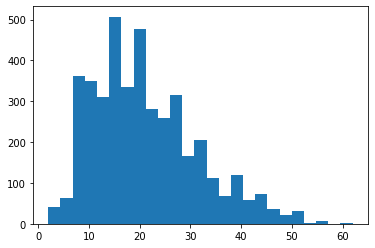

In [16]:
plt.hist(sent_lens, bins=25);

In [17]:
MAX_SENT_LEN = int(np.percentile(sent_lens, 95))
MAX_SENT_LEN

41

# Vectorization

In [19]:
MAX_VOCAB_LEN = 12_000


txt_vect = TextVectorization(max_tokens=MAX_VOCAB_LEN,
                             output_mode="int",
                             pad_to_max_tokens=True,
                             output_sequence_length=MAX_SENT_LEN)

In [20]:
txt_vect.adapt(train_sentences)

In [21]:
# Vocab len

vocab_len = txt_vect.get_vocabulary()
print(len(vocab_len))

10713


# Functions

In [22]:
def compile_model(model):
  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  
def fit_model(model, epochs):
  model.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=epochs,
            validation_data=val_dataset,
            validation_steps=int(0.1*len(val_dataset)))

In [23]:
# Ripping eval function from other project since im lazy

def calculate_results(y_true, y_pred):
  """
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
def acc_loss(model):
  loss, accuracy = model.evaluate(val_dataset, verbose=1)
  print(f"Loss: {loss*100:2f}\nAccuracy: {accuracy*100:2f}")

# Performant Datasets LUL

In [25]:
# Creating dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [26]:
# Batching and prefetching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

# Conv1D Model

In [27]:
Embedding = keras.layers.Embedding(input_dim=MAX_VOCAB_LEN,
                                      output_dim=128,
                                      input_length=MAX_SENT_LEN)

In [28]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype=tf.string)

text_vectorizer = txt_vect(inputs)

token_embeddings = Embedding(text_vectorizer)

# Conv1D
x = keras.layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(token_embeddings)

# Pooling Layer POGGERS
x = keras.layers.GlobalAveragePooling1D()(x)

# Output
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Create Model
model_0 = tf.keras.Model(inputs, outputs, name="Baseline_Model")

In [29]:
model_0.summary()

Model: "Baseline_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 41)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 41, 128)           1536000   
                                                                 
 conv1d (Conv1D)             (None, 41, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 3)              

In [30]:
compile_model(model_0)

In [31]:
hist_0 = fit_model(model_0, 10)

Epoch 1/10
13/13 [==============================] - 9s 19ms/step - loss: 1.0367 - accuracy: 0.5625 - val_loss: 1.0571 - val_accuracy: 0.4375
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 0.9490 - accuracy: 0.5697 - val_loss: 1.0498 - val_accuracy: 0.4375
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5457 - val_loss: 0.9892 - val_accuracy: 0.4375
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.9884 - accuracy: 0.5192 - val_loss: 0.9711 - val_accuracy: 0.4375
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 1.0118 - accuracy: 0.4856 - val_loss: 0.9681 - val_accuracy: 0.4375
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 0.9285 - accuracy: 0.5457 - val_loss: 0.9407 - val_accuracy: 0.4375
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.9266 - accuracy: 0.5288 - val_loss: 0.8965 - val_accuracy: 0.5625
Epoch 8/10
13/13 [=

In [32]:
acc_loss(model_0)

15/15 [==============================] - 0s 4ms/step - loss: 0.8353 - accuracy: 0.6154
Loss: 83.533204
Accuracy: 61.538464


## Making Preds

In [33]:
model_0_pred_probs = model_0.predict(val_dataset)
model_0_pred_probs

array([[0.08932148, 0.6904651 , 0.22021343],
       [0.00616576, 0.96888095, 0.02495332],
       [0.17277065, 0.47604787, 0.3511815 ],
       ...,
       [0.09661603, 0.6477144 , 0.25566956],
       [0.14973955, 0.5165127 , 0.33374777],
       [0.24070331, 0.3215675 , 0.43772924]], dtype=float32)

In [34]:
# Preds to classes
model_0_preds = tf.argmax(model_0_pred_probs, axis=1)
model_0_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 2, 1])>

### Calculate Results

In [35]:
model_0_results = calculate_results(val_labels_encoded,
                                    model_0_preds)
model_0_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 61.53846153846154,
 'f1': 0.5573800123556291,
 'precision': 0.5226402754534788,
 'recall': 0.6153846153846154}

# Conv1D w/ More Layers

In [61]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype=tf.string)

text_vectorizer = txt_vect(inputs)

token_embeddings = Embedding(text_vectorizer)

# Conv1D
x = keras.layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)

# Pooling Layer POGGERS
x = keras.layers.GlobalAveragePooling1D()(x)

# Output
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Create Model
model_1 = tf.keras.Model(inputs, outputs, name="Conv1D_More_Layers")

In [62]:
model_1.summary()

Model: "Conv1D_More_Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 41)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 41, 128)           1536000   
                                                                 
 conv1d_9 (Conv1D)           (None, 41, 64)            41024     
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 3)          

In [63]:
compile_model(model_1)

In [64]:
hist_1 = fit_model(model_1, 10)

Epoch 1/10
13/13 [==============================] - 1s 23ms/step - loss: 0.9406 - accuracy: 0.5793 - val_loss: 0.9406 - val_accuracy: 0.4375
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 0.7793 - accuracy: 0.5889 - val_loss: 0.8280 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 0.7274 - accuracy: 0.7332 - val_loss: 0.7112 - val_accuracy: 0.6250
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6794 - accuracy: 0.7380 - val_loss: 0.6785 - val_accuracy: 0.6875
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 0.6254 - accuracy: 0.7620 - val_loss: 0.6704 - val_accuracy: 0.7812
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 0.5035 - accuracy: 0.8317 - val_loss: 0.6371 - val_accuracy: 0.7812
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.8341 - val_loss: 0.6346 - val_accuracy: 0.7500
Epoch 8/10
13/13

In [65]:
acc_loss(model_1)

15/15 [==============================] - 0s 9ms/step - loss: 0.7297 - accuracy: 0.6838
Loss: 72.971344
Accuracy: 68.376070


## Making Preds

In [66]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[0.07235382, 0.8202462 , 0.10739998],
       [0.00160212, 0.99674904, 0.00164884],
       [0.17131162, 0.04095485, 0.7877335 ],
       ...,
       [0.08594947, 0.7161464 , 0.19790418],
       [0.17323339, 0.41387618, 0.41289043],
       [0.16349788, 0.01706535, 0.8194368 ]], dtype=float32)

In [67]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 2, 2, 1])>

### Calculate Results

POGGERS 7% better with just adding one more Conv1D Layer.

In [68]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds
                                    )
model_1_results

{'accuracy': 68.37606837606837,
 'f1': 0.6770781850697845,
 'precision': 0.6746611592150413,
 'recall': 0.6837606837606838}

In [69]:
model_0_results

{'accuracy': 61.53846153846154,
 'f1': 0.5573800123556291,
 'precision': 0.5226402754534788,
 'recall': 0.6153846153846154}

# Pre-Trained Embeddings Model

In [72]:
# pretrained USE emebddings (takes 30s to load)
USE_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [75]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=[], dtype=tf.string)

# Embedding Layer
USE_pretrained = USE_embed_layer(inputs)

# Dense Layer
x = keras.layers.Dense(128, activation="relu")(USE_pretrained)

# Dense output
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Create model
model_2 = tf.keras.Model(inputs, outputs, name="USE_Pretrained_Model")

In [76]:
model_2.summary()


Model: "USE_Pretrained_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 256,863,875
Trainable params: 66,051
Non-trainable params: 256,797,824
_________________________________________________________________


In [77]:
compile_model(model_2)

In [78]:
hist_2 = fit_model(model_2, 10)

Epoch 1/10
13/13 [==============================] - 5s 50ms/step - loss: 1.0590 - accuracy: 0.5288 - val_loss: 1.0345 - val_accuracy: 0.4375
Epoch 2/10
13/13 [==============================] - 0s 26ms/step - loss: 0.9649 - accuracy: 0.5938 - val_loss: 0.9703 - val_accuracy: 0.4375
Epoch 3/10
13/13 [==============================] - 0s 16ms/step - loss: 0.9336 - accuracy: 0.5697 - val_loss: 0.9310 - val_accuracy: 0.5000
Epoch 4/10
13/13 [==============================] - 0s 17ms/step - loss: 0.9103 - accuracy: 0.5889 - val_loss: 0.8935 - val_accuracy: 0.5625
Epoch 5/10
13/13 [==============================] - 0s 23ms/step - loss: 0.9254 - accuracy: 0.5986 - val_loss: 0.8735 - val_accuracy: 0.5312
Epoch 6/10
13/13 [==============================] - 0s 24ms/step - loss: 0.8270 - accuracy: 0.6562 - val_loss: 0.8558 - val_accuracy: 0.6250
Epoch 7/10
13/13 [==============================] - 0s 25ms/step - loss: 0.8269 - accuracy: 0.6274 - val_loss: 0.8359 - val_accuracy: 0.5625
Epoch 8/10
13

In [79]:
acc_loss(model_2)

15/15 [==============================] - 0s 21ms/step - loss: 0.7321 - accuracy: 0.7009
Loss: 73.214602
Accuracy: 70.085472


## Making Preds

In [80]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[0.14137413, 0.60148597, 0.25713995],
       [0.10283924, 0.5573001 , 0.33986065],
       [0.29572293, 0.15924072, 0.5450363 ],
       ...,
       [0.08222849, 0.6108777 , 0.30689383],
       [0.11590403, 0.6509485 , 0.23314747],
       [0.23018886, 0.23761444, 0.5321967 ]], dtype=float32)

In [82]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 2, 2, 2])>

### Calculate Results

POGGERS. 2% improvement on accuracy

In [84]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 70.08547008547008,
 'f1': 0.6818744473916888,
 'precision': 0.6816224968742955,
 'recall': 0.7008547008547008}

In [85]:
model_1_results

{'accuracy': 68.37606837606837,
 'f1': 0.6770781850697845,
 'precision': 0.6746611592150413,
 'recall': 0.6837606837606838}

In [86]:
model_0_results

{'accuracy': 61.53846153846154,
 'f1': 0.5573800123556291,
 'precision': 0.5226402754534788,
 'recall': 0.6153846153846154}